In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
from lsst.all_sky_phot.wcs import Fisheye, load_fisheye
from lsst.all_sky_phot import forced_phot, readYBC, readcr2, lsst_earth_location, radec2altaz
import healpy as hp

import photutils as phu
import time

In [2]:
# Load up the WCS we fit in Full_WCS_fit (generated in notebook Full_WCS_fit)
wcs = load_fisheye('fisheye_wcs.npz')

In [3]:
# Load the Yale Bright Star catalog
ybc = readYBC()

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/pandas/io/parsers.py:710: UserWarning: Duplicate names specified. This will raise an error in the future.
  return _read(filepath_or_buffer, kwds)


In [4]:
# Read in an image
filename = 'ut012716/ut012716.0130.long.cr2'
im, header = readcr2(filename)
# Combine the RGB into a single image
sum_image = np.sum(im, axis=2).astype(float)


In [6]:
# Compute the expected catalog alt and az

alt_cat, az_cat = radec2altaz(ybc['RA'].values, ybc['Dec'].values, header['mjd'])
above = np.where(alt_cat > 15.)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

In [8]:
zp = 18.
nside = 16
t0 = time.time()
# Get the catalog stuff in there
alt_cat, az_cat = radec2altaz(ybc['RA'].values, ybc['Dec'].values, header['mjd'])
above = np.where(alt_cat > 15.)
emap = forced_phot(sum_image, wcs, zp, alt_cat[above], az_cat[above],
                   ybc['Vmag'].values[above], ybc['HR'].values[above],
                   nside=nside)
t1 = time.time()
print('runtime=%.1f s' % (t1-t0))

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/pyt

runtime=0.5 s


/Users/yoachim/gitRepos/all_sky_phot/python/lsst/all_sky_phot/forced_phot.py:96: RuntimeWarning: invalid value encountered in log10
  phot_table['residual_aperture_mag'] = -2.5*np.log10(final_sum) + zp


In [9]:
above[0].size

3636

/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/pixelfunc.py:304: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/numpy/ma/core.py:2344: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1049: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsstp3/stack/miniconda3-4.3.21-10a4fa6/DarwinX86/healpy/1.10.3.lsst1+6/lib/python/healpy-1.10.3-py3.6-macosx-10.7-x86_64.egg/healpy/projaxes.py:1050: RuntimeWarning: invalid value encountered in greater
  result.data[result.data>1]=1.0


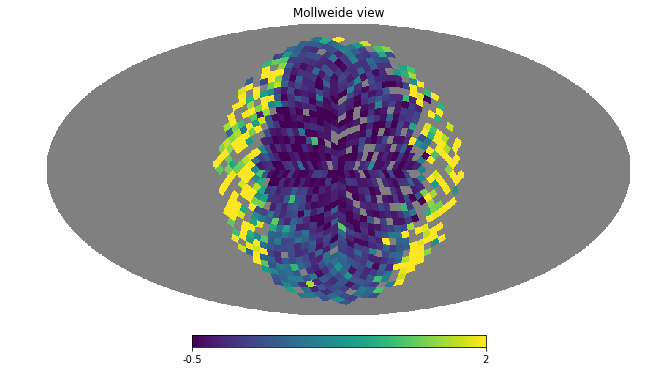

In [10]:
hp.mollview(emap, rot=[0,90,0], min=-.5, max=2)

In [11]:
# Let's look at how well we are doing with the wcs
catalog_x, catalog_y = wcs.all_world2pix(az_cat[above], alt_cat[above], 0)
good_transform = ~np.isnan(catalog_x)
positions = list(zip(catalog_x[good_transform], catalog_y[good_transform]))
apertures = phu.CircularAperture(positions, r=5.)

/Users/yoachim/lsstp3/python/miniconda3-4.3.21/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


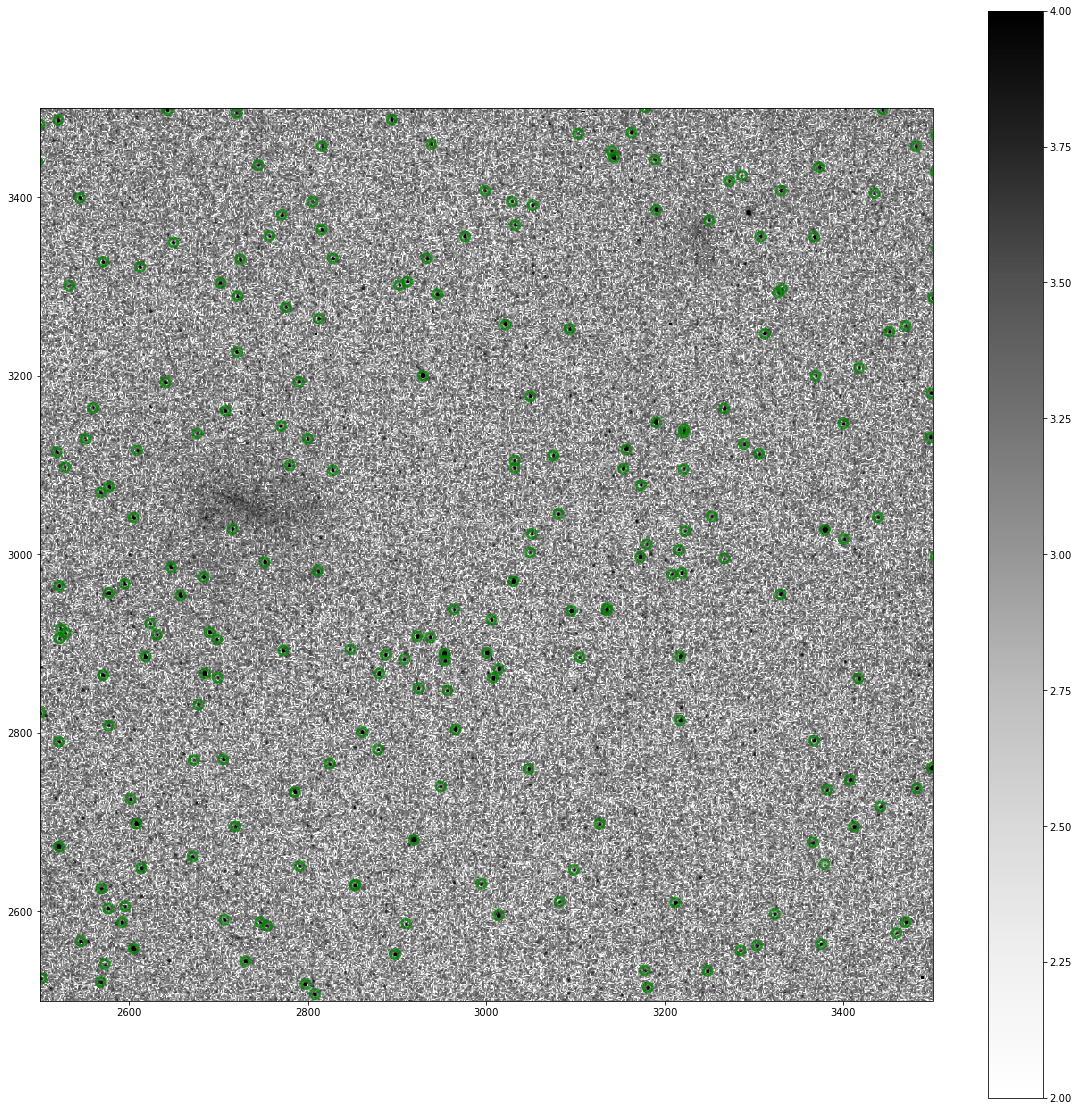

In [12]:
plt.figure(figsize=[20,20])
plt.imshow(np.log10(sum_image),  cmap='Greys', origin='lower', vmin=2, vmax=4)
plt.colorbar()
plt.xlim([2500,3500])
plt.ylim([2500,3500])
apertures.plot(color='green', lw=3, alpha=0.75)

In [11]:
hp.nside2resol(16, arcmin=True)/60.

3.6645188392718997